In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

## Governing Equations

\begin{equation}
\frac{dM}{dt} = F_h - F_m - F_a
\end{equation}

\begin{equation}
\frac{d\delta}{dt} = \frac{1}{M}\left[F_h(\delta_h - \delta) - F_m\Delta_m - F_a\Delta_a \right]
\end{equation}


**Note that in this model $\delta_h$, $\Delta_m$, and $\Delta_a$ are fixed for each model run.** Also, $\Delta_i = \delta_i - \delta$

In [2]:
import numpy as np
import scipy.integrate
import scipy.optimize as opt
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{textcomp}')
%matplotlib inline


# default parameter values

F_h_d = 1.3e10
F_m_d = 1.1e10
F_a_d = 1.2e10
F_r_d = 0.2*1e10   # river flux, modern value is 1e10 mol/yr

delta_r_d = 0.023  # value for river flux
delta_h_d = 0.0083
Delta_a_d = -0.013
Delta_m_d = -0.02

In [3]:
# Numerical ODE set

def gov_eq(t, y, F_h=F_h_d, F_m=F_m_d, F_a=F_a_d, delta_h=delta_h_d, Delta_a=Delta_a_d, Delta_m=Delta_m_d):
            
    dMdt      = F_h - F_m - F_a
    ddeltadt  = (F_h*(delta_h - y[1]) - F_m*Delta_m - F_a*Delta_a)/y[0]
    
    return [dMdt, ddeltadt]

In [4]:
# Initial Conditions

M0        = 3.575e16
delta0    = 0.031
y0        = [M0, delta0]

max_time  = M0/(-F_h_d + F_m_d + F_a_d)

In [5]:
print((F_h_d*(delta_h_d - delta0) - F_m_d*Delta_m_d - F_a_d*Delta_a_d)/M0)  # positive value indicates an increasing trend

2.262937062937063e-09


## Note
Because $M = M_0 - t (F_a - F_h + F_m)$, $M$ will become negative and meaningless when time exceeds the max_time of ~3.5 Ma.

In [6]:
time_span = (0, max_time)   # in Ma
time_step  = np.linspace(0, max_time-1, num=2000, endpoint=True)  # time for the solution points

In [7]:
max_time

3575000.0

In [8]:
sol = scipy.integrate.solve_ivp(gov_eq, time_span, y0, method='LSODA', t_eval=time_step)

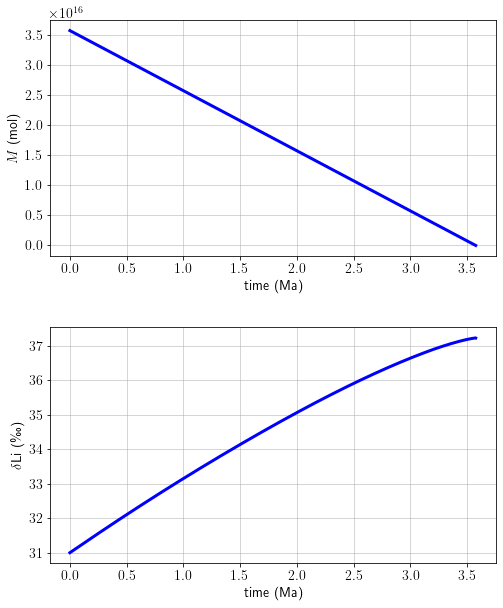

In [9]:
FONT_SIZE = 14
lw        = 3

f = plt.figure(figsize=(8,10))   # results for a default fixed Delta_m = 0.02, plotted for sanity check

# formatter for yaxis tick labels
fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_scientific(True)
fmt.set_powerlimits((-2, 2))
plt.subplot(2,1,1)
plt.plot(sol.t/1e6, sol.y[0], color='b', linewidth=lw)
plt.xlabel('time (Ma)', size=FONT_SIZE)
plt.ylabel(r'$M$ (mol)', size=FONT_SIZE)
plt.tick_params(labelsize=FONT_SIZE)
plt.gca().yaxis.get_offset_text().set_fontsize(FONT_SIZE)
plt.gca().yaxis.set_major_formatter(fmt)
plt.grid(which='major', alpha=0.65)

fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_scientific(True)
fmt.set_powerlimits((-2, 2))
plt.subplot(2,1,2)
plt.plot(sol.t/1e6, sol.y[1]*1e3, color='b', linewidth=lw)
plt.xlabel('time (Ma)', size=FONT_SIZE)
plt.ylabel(r'$\delta$Li (\textperthousand)', size=FONT_SIZE)
plt.gca().yaxis.get_offset_text().set_fontsize(FONT_SIZE)
plt.gca().yaxis.set_major_formatter(fmt)
plt.tick_params(labelsize=FONT_SIZE)
plt.grid(which='major', alpha=0.65)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
#f.savefig('default.png', dpi = 300)

In [10]:
dm_range         = np.linspace(-0.02, 0, num=500, endpoint=True)  # corresponds to delta_ from 0 to 0.011
t_grid, m_grid   = np.meshgrid(time_step, dm_range)
delta_mat        = np.empty(t_grid.shape)

for i, dm in enumerate(dm_range):
    p_list       = (F_h_d, F_m_d, F_a_d, delta_h_d, Delta_a_d, dm)
    sol          = scipy.integrate.solve_ivp(gov_eq, time_span, y0, method='LSODA', args=p_list, t_eval=time_step)
    delta_mat[i] = sol.y[1]

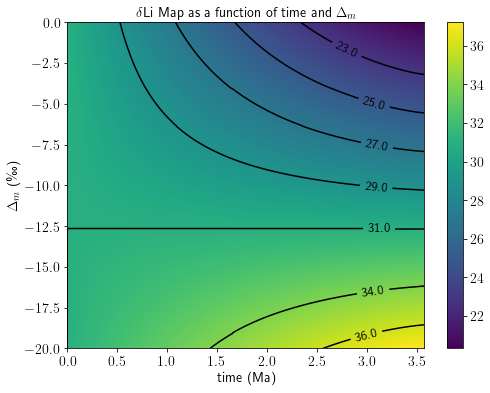

In [11]:
fig     = plt.figure(figsize=(8,6))

mesh1   = plt.pcolormesh(t_grid/1e6, m_grid*1e3, delta_mat*1e3, cmap='viridis', shading='auto')
plt.xlim(0,max_time/1e6)
plt.ylim(dm_range[0]*1e3, 0)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=FONT_SIZE)

clevel  = [23, 25, 27, 29, delta0*1e3+1e-12, 34, 36]
cs      = plt.contour(t_grid/1e6, m_grid*1e3, delta_mat*1e3, levels=clevel, colors='k')
labels  = plt.clabel(cs, inline=1, fontsize=13, fmt='%3.1f')

fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_scientific(True)
fmt.set_powerlimits((-2, 2))
plt.title('$\delta$Li Map as a function of time and $\Delta_m$', fontsize=FONT_SIZE)
plt.xlabel('time (Ma)', fontsize=FONT_SIZE)
plt.ylabel(r'$\Delta_m$ (\textperthousand)', fontsize=FONT_SIZE)
plt.tick_params(labelsize=FONT_SIZE)
plt.gca().yaxis.set_major_formatter(fmt)
fig.savefig('delta_Li_map.png', dpi = 300)
#plt.colorbar(mesh1, ax=ax1, orientation='horizontal')
#ax1.text(1.0, 0.9, r"$\phi'$", fontweight="bold", fontsize="x-large")

## Analysis of the model behavior

1. The maximum time duration for this model can be easily obtained because the first governing equation is decoupled from the second, which leads to the solution $M = M_0 - t (F_a - F_h + F_m)$. To have positive and meaningful $M$ values requires that $M = M_0 - t (F_a - F_h + F_m) > 0$, i.e., $t < \frac{M_0}{F_a - F_h + F_m} \approx$ 3.5 Ma for default values of $M_0$, $F_a$, $F_h$ and $F_m$. All the plots therefore have a time range of (0, max_time).


2. $\Delta_m = 0.02$ defines the default parameter for this model, and the corresponding results are shown by blue lines in the first figure. In this default model setup, $M$ decreases with time because $F_a - F_h + F_m > 0$, whereas $\delta$Li increases with time.

3. The increasing trend of $\delta$Li for $\Delta_m = 0.02$ is also anticipated because, at least near $t=0$ Ma, $\frac{d\delta}{dt} = \frac{1}{M}\left[F_h(\delta_h - \delta) - F_m\Delta_m - F_a\Delta_a \right] > 0$ if we substitute into the initial values of $M$, $\delta$ and other parameter values.

4. However, since we can vary $\Delta_m$, at $t=0$ Ma, there exists a turning point where $\frac{d\delta}{dt} = \frac{1}{M}\left[F_h(\delta_h - \delta) - F_m\Delta_m - F_a\Delta_a \right]$ changes from $\frac{d\delta}{dt}=0$ to $\frac{d\delta}{dt}<0$. In other words, $\delta$Li increases with time when $\Delta_m < \Delta_m^{turning\ point}$, but decreases with time when $\Delta_m > \Delta_m^{turning\ point}$. This model behavior is demonstrated in the second figure where we can see $\Delta_m^{turning\ point} \approx -0.0125$.

5. In the second figure, it is also no surprise that $\Delta_m = \Delta_m^{turning\ point} \approx -0.0125$ corresponds to the horizontal contour line of $\delta$Li$=\delta_0 = 0.031$ because $\frac{d\delta}{dt} = \frac{1}{M}\left[F_h(\delta_h - \delta) - F_m\Delta_m - F_a\Delta_a \right]$ always equals to $0$ when $\Delta_m = \Delta_m^{turning\ point}$.

## New plot showing the difference between $\delta$ and $\delta_0$

Based on the last point in the analysis above, it will be interesting to plot the difference between $\delta$ and $\delta_0$ to show the divergent model behaviors dictated by the value of $\Delta_m$.

In the figure below, **red** color denotes $\delta$Li increase from its initial value, **blue** color denotes the decrease, and **white** color denotes no change (fixed point in the theory of dynamic systems).

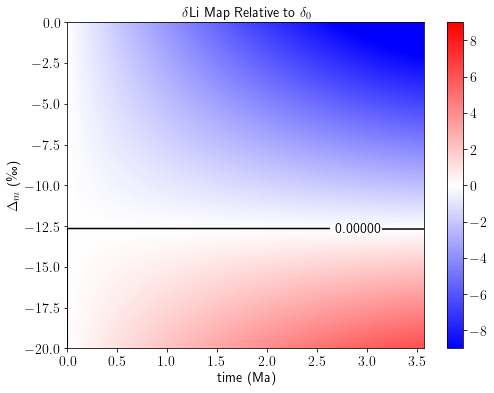

In [12]:
fig     = plt.figure(figsize=(8,6))

mesh1   = plt.pcolormesh(t_grid/1e6, m_grid*1e3, (delta_mat-delta0)*1e3, cmap='bwr', vmin=-9, vmax=9, shading='auto')
plt.xlim(0,max_time/1e6)
plt.ylim(dm_range[0]*1e3, 0)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=FONT_SIZE)

cs      = plt.contour(t_grid/1e6, m_grid*1e3, (delta_mat-delta0)*1e3, levels=[1e-12], colors='k')
labels  = plt.clabel(cs, inline=1, inline_spacing=-5, fontsize=FONT_SIZE)
pos     = [t.set_color((0.1, 0.1, 0.1, 0.0)) for t in labels]
labels  = plt.clabel(cs, inline=1, levels=[1e-12], fontsize=FONT_SIZE, fmt='%6.5f')

fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_scientific(True)
fmt.set_powerlimits((-2, 2))
plt.title('$\delta$Li Map Relative to $\delta_0$', fontsize=FONT_SIZE)
plt.xlabel('time (Ma)', fontsize=FONT_SIZE)
plt.ylabel(r'$\Delta_m$ (\textperthousand)', fontsize=FONT_SIZE)
plt.tick_params(labelsize=FONT_SIZE)
plt.gca().yaxis.set_major_formatter(fmt)
fig.savefig('delta_Li_to_Li0_map.png', dpi = 300)

## Simplified Governing Equations for Additional River Flux

\begin{equation}
\frac{dM}{dt} = F_r + F_h - F_m - F_a
\end{equation}

\begin{equation}
\frac{d\delta}{dt} = \frac{1}{M}\left[F_r(\delta_r - \delta) + F_h(\delta_h - \delta) - F_m\Delta_m - F_a\Delta_a \right]
\end{equation}

In [13]:
# Numerical ODE set

def gov_eq_Riv(t, y, F_r=F_r_d, F_h=F_h_d, F_m=F_m_d, F_a=F_a_d, delta_r=delta_r_d, delta_h=delta_h_d, Delta_a=Delta_a_d, Delta_m=Delta_m_d):
            
    dMdt      = F_r + F_h - F_m - F_a
    ddeltadt  = (F_r*(delta_r - y[1]) + F_h*(delta_h - y[1]) - F_m*Delta_m - F_a*Delta_a)/y[0]
    
    return [dMdt, ddeltadt]

In [14]:
dm_range         = np.linspace(-0.02, 0, num=500, endpoint=True)  # corresponds to delta_ from 0 to 0.011
t_grid, m_grid   = np.meshgrid(time_step, dm_range)
delta_mat        = np.empty(t_grid.shape)

for i, dm in enumerate(dm_range):
    p_list       = (F_r_d, F_h_d, F_m_d, F_a_d, delta_r_d, delta_h_d, Delta_a_d, dm)
    sol          = scipy.integrate.solve_ivp(gov_eq_Riv, time_span, y0, method='LSODA', args=p_list, t_eval=time_step)
    delta_mat[i] = sol.y[1]

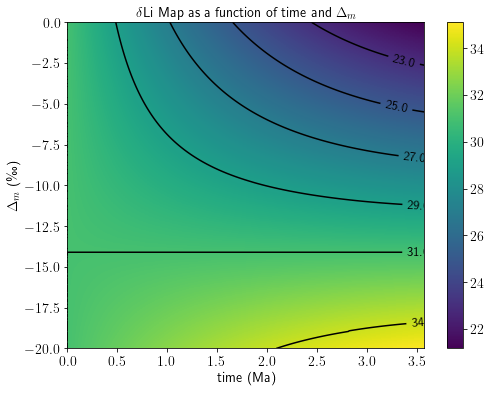

In [15]:
fig     = plt.figure(figsize=(8,6))

mesh1   = plt.pcolormesh(t_grid/1e6, m_grid*1e3, delta_mat*1e3, cmap='viridis', shading='auto')
plt.xlim(0,max_time/1e6)
plt.ylim(dm_range[0]*1e3, 0)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=FONT_SIZE)

clevel  = [23, 25, 27, 29, delta0*1e3, 34]
cs      = plt.contour(t_grid/1e6, m_grid*1e3, delta_mat*1e3, levels=clevel, colors='k')
labels  = plt.clabel(cs, inline=1, fontsize=13, fmt='%3.1f')

fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_scientific(True)
fmt.set_powerlimits((-2, 2))
plt.title('$\delta$Li Map as a function of time and $\Delta_m$', fontsize=FONT_SIZE)
plt.xlabel('time (Ma)', fontsize=FONT_SIZE)
plt.ylabel(r'$\Delta_m$ (\textperthousand)', fontsize=FONT_SIZE)
plt.tick_params(labelsize=FONT_SIZE)
plt.gca().yaxis.set_major_formatter(fmt)
fig.savefig('delta_Li_map_Riv.png', dpi = 300)
#plt.colorbar(mesh1, ax=ax1, orientation='horizontal')
#ax1.text(1.0, 0.9, r"$\phi'$", fontweight="bold", fontsize="x-large")

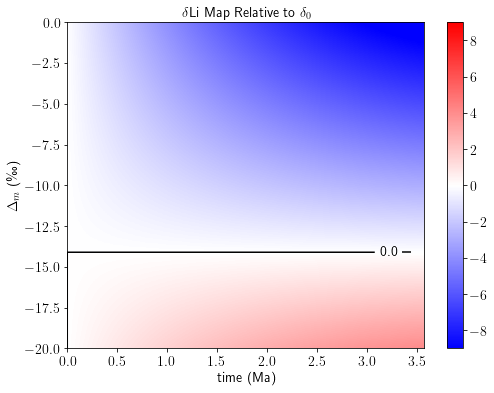

In [16]:
fig     = plt.figure(figsize=(8,6))

mesh1   = plt.pcolormesh(t_grid/1e6, m_grid*1e3, (delta_mat-delta0)*1e3, cmap='bwr', vmin=-9, vmax=9, shading='auto')
plt.xlim(0,max_time/1e6)
plt.ylim(dm_range[0]*1e3, 0)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=FONT_SIZE)

cs      = plt.contour(t_grid/1e6, m_grid*1e3, (delta_mat-delta0)*1e3, levels=[1e-12], colors='k')
labels  = plt.clabel(cs, inline=1, inline_spacing=-5, fontsize=FONT_SIZE)
pos     = [t.set_color((0.1, 0.1, 0.1, 0.0)) for t in labels]
labels  = plt.clabel(cs, inline=1, levels=[1e-12], fontsize=FONT_SIZE, fmt='%3.1f')

fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_scientific(True)
fmt.set_powerlimits((-2, 2))
plt.title('$\delta$Li Map Relative to $\delta_0$', fontsize=FONT_SIZE)
plt.xlabel('time (Ma)', fontsize=FONT_SIZE)
plt.ylabel(r'$\Delta_m$ (\textperthousand)', fontsize=FONT_SIZE)
plt.tick_params(labelsize=FONT_SIZE)
plt.gca().yaxis.set_major_formatter(fmt)
fig.savefig('delta_Li_to_Li0_map_Riv.png', dpi = 300)